# A basic notebook for stacking NN predictions

In [1]:
import pylab as p
from numpy import *
import pandas as pd
from tqdm import tqdm
import lightgbm as lgbm
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import log_loss as skl_log_loss
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score as skl_roc_auc_score

### Custom functions

In [2]:
def my_log_loss(ytrue, ypred):
    ll = zeros(6)
    for i in range(6):
        ll[i] = skl_log_loss(ytrue[:,i], ypred[:,i])
    return ll.mean()

### Read in the original data

In [3]:
# Read in the TOXIC competition data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# Target labels
ycols = train.columns[2:]
ys = train[ycols].values

print('Reading the challenge data...')
print( '%-27s %-10i' % ('Size of the training set:', len(train)))
print( '%-27s %-10i' % ('Size of the testing set:', len(test)))
print()

Reading the challenge data...
Size of the training set:   159571    
Size of the testing set:    153164    



### Read in the master data file

In [4]:
master_list = pd.read_csv('../xmodel_list.txt', delim_whitespace=True, names=['id', 'logloss', 'roc'])

### Read in all available NN predictions

In [5]:
# Reading the data in
dftrain = zeros((len(master_list), train.shape[0], 6))
dftest  = zeros((len(master_list), test.shape[0], 6))
for i,v in enumerate(tqdm(master_list['id'].values)):
    dftrain[i] = pd.read_csv('../xvalidations/'+v[:-1]+'.csv.bz', compression='bz2')[ycols].values
    dftest[i]  = pd.read_csv('../xsubmissions/'+v[:-1]+'.csv')[ycols].values

# # The scaling (overwritting the original stuff, in memory of course)
# for i,v in enumerate(dfs):
#     dfs[i] = minmax_scale(v)

# for i,v in enumerate(dds):
#     dds[i] = minmax_scale(v)

100%|██████████| 34/34 [01:07<00:00,  2.00s/it]


### Choose the best models
 - this was done in the bagging notebook

In [6]:
### I did this in the xgb case.. but perhaps it would be better to try with all models
### Boosted tree algorithms should (in principle) be insensitive to uninformative features..
### But feel free to experiment as you see fit, naturally.

### Prepare the data for the training process
- for now use all the available data, for everything.. Kinda messy, but let's see... trees should be insensitive to uninformative features..
- the `hstack` converts the dftrain into a format where columns from the different models are collapsed into a single model

In [7]:
X = hstack(dftrain)
Y = hstack(dftest)

## Stacking with  `LightGBM`

In [11]:
# My own lgbm model class, useful for training stuff on the fly, with x-validations and all

class lgbm_model():
    def __init__(self, X, label, Y):
        '''
        params:
        X     = sparse matrix csr format (training set)
        label = 1-d array, same length as X, the target value
        Y     = sparse matrix csr format (test set)
        '''
        self.X     = X
        self.label = label
        self.Y     = Y
    
    def run_lgbm_model(self, params, num_boost_round, num_folds=5, verbose_eval=False, show_plot=True):
        
        # The KFold object
        kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)
        
        # The history for the plots
        hh = tmp = [{} for _ in range(num_folds)]
        
        # metrics
        val_loss = zeros(num_folds)
        val_roc = zeros(num_folds)
        
        # predictions on the validation set
        vvpred = zeros(num_folds, dtype='O')
        
        # The test results predictions from each fold
        pred = zeros((num_folds, 153164))
        
        # The training the KFold x-validation starts here
        for i, (ind_train, ind_val) in enumerate(kf.split(self.X)):
            XX, VV = self.X[ind_train], self.X[ind_val]
            yx, yv = self.label[ind_train], self.label[ind_val]
            
            # Convert the training and validation set into the lgbm format
            dtrain = lgbm.Dataset(data=XX, label=yx)
            dval   = lgbm.Dataset(data=VV, label=yv)
            
            # The booster model for the given data
            booster = lgbm.train(params=params, 
                                 train_set=dtrain, 
                                 num_boost_round=num_boost_round, 
                                 valid_sets=[dtrain,dval],
                                 valid_names=['train','val'],
                                 evals_result=hh[i],
#                                  learning_rates=self.learning_rate_decay,
                                 early_stopping_rounds=31,
                                 verbose_eval=verbose_eval)
            
            
            # Predictions on the validation set
            vvpred[i] = booster.predict(VV)
                        
            # Record the metrics
            val_loss[i] = skl_log_loss(yv, vvpred[i])
            val_roc[i] = skl_roc_auc_score(yv, vvpred[i])
            
            # Predictions onthe test set
            pred[i] = booster.predict(self.Y)

        # Plot the loss function as a diagnostic
        if show_plot:
            p.figure(figsize=(9,6))
            for i in range(num_folds):
                p.plot((hh[i]['train']['binary_logloss']), lw=2, ls='solid')
                p.plot((hh[i]['val']['binary_logloss']), lw=2, ls='dashed')
            p.show()
        
        # Collect the results
        print()
        print('Average logloss across the x-validation folds: %2.6f' % (val_loss.mean()))
        print('Average roc-auc across the x-validation folds: %2.6f' % (val_roc.mean()))
        
        # Stack the predictions from the validation and test sets
        vvpred = hstack(vvpred)
        pred = pred.mean(axis=0)
        
        return vvpred, pred

    def learning_rate_decay(self,i):        
        if (i<=10):
            lr = 0.2
        elif (10<i) & (i<=100):
            lr = 0.1
        elif (100<i) & (i<=300):
            lr = 0.05
        elif (300<i) & (i<=500):
            lr =  0.01
        elif (500<i) & (i<=1000):
            lr = 0.005
        else:
            lr = 0.001

        return lr


Predicting toxic comments


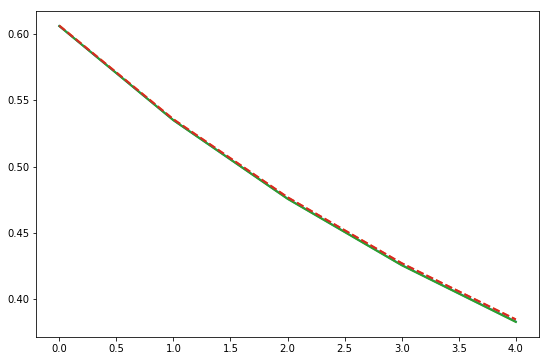


Average logloss across the x-validation folds: 0.384376
Average roc-auc across the x-validation folds: 0.985106


Predicting severe_toxic comments


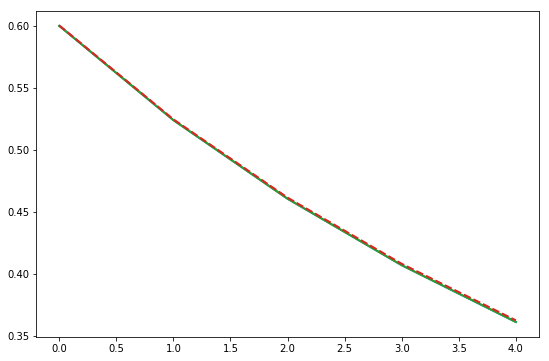


Average logloss across the x-validation folds: 0.362549
Average roc-auc across the x-validation folds: 0.981392


Predicting obscene comments


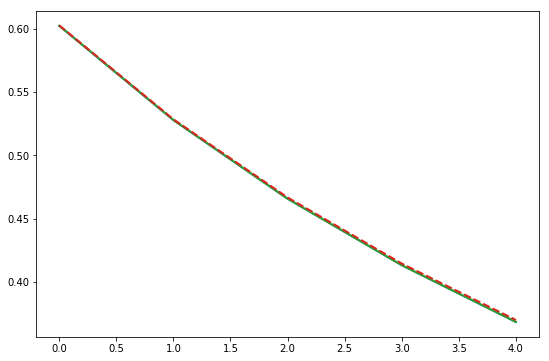


Average logloss across the x-validation folds: 0.370033
Average roc-auc across the x-validation folds: 0.991683


Predicting threat comments


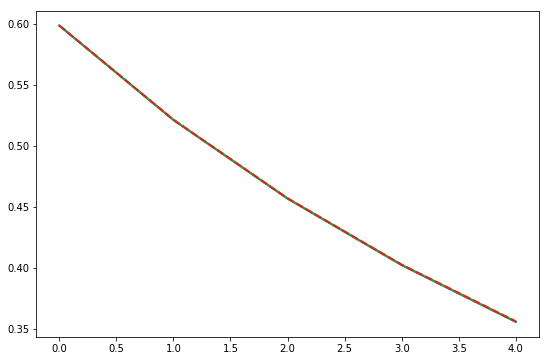


Average logloss across the x-validation folds: 0.356406
Average roc-auc across the x-validation folds: 0.935436


Predicting insult comments


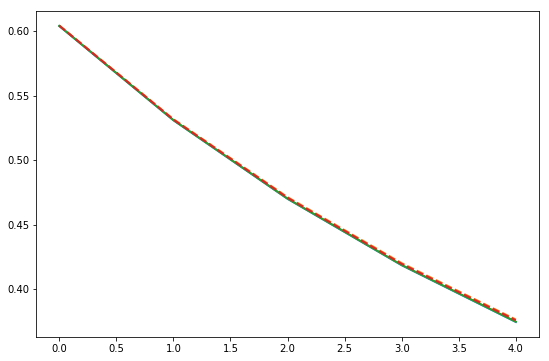


Average logloss across the x-validation folds: 0.376236
Average roc-auc across the x-validation folds: 0.985036


Predicting identity_hate comments


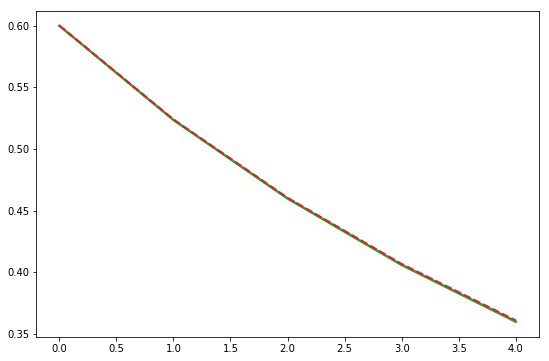


Average logloss across the x-validation folds: 0.360730
Average roc-auc across the x-validation folds: 0.963207


The final veridict:
Average logloss across the x-validation folds: 0.36838821
Average roc-auc across the x-validation folds: 0.97286037
CPU times: user 1min 55s, sys: 5.09 s, total: 2min
Wall time: 47.6 s


In [16]:
%%time

# This cell runs the full LightGBM model accross the entire toxic dataset

# The parameters for the training process
params = {
    'boosting': 'gbdt',
    'max_depth': 7,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'application': 'binary',
    'metric': 'binary_logloss',
    'num_threads': 8,
    'min_data_in_leaf': 20,
    'subsample': 0.80,
    'colsample_bytree': 0.80,
    'reg_lambda': 0.5,
    'reg_alpha': 1.5,
}

# This is where the outputs are stored
lgbm_vvpred = zeros((len(ycols), X.shape[0]))
lgbm_pred   = zeros((len(ycols), Y.shape[0]))

for i,v in enumerate(ycols):
    print('Predicting %s comments' % (v))
    # instantiating my own lgbm_model class
    booster = lgbm_model(X=X, label=ys[:,i],  Y=Y)
    lgbm_vvpred[i], lgbm_pred[i] = booster.run_lgbm_model(params=params, num_boost_round=5, num_folds=2)
    print('')
    print('')

print('The final veridict:')
print('Average logloss across the x-validation folds: %2.8f' % (my_log_loss(ys, lgbm_vvpred.T)))
print('Average roc-auc across the x-validation folds: %2.8f' % (skl_roc_auc_score(ys, lgbm_vvpred.T)))


### If the results are satisfactory

In [ ]:
print('')
print('Saving the final results to disk...')
# Save to disk the prediction for the training set from the x-validation folds
df_valid = train.copy()
df_valid[ycols] = pd.DataFrame(lgbm_vvpred.T, columns=ycols)
df_valid.to_csv('./results/lgbm_xval.csv', index=False)

# Creating the submission file
submission = pd.read_csv('../sample_submission.csv')
submission[ycols] = pd.DataFrame(lgbm_pred.T, columns=ycols)
submission.to_csv('./results/lgbm_submission.csv', index=False)
print('All done!')
print('')